# Including 
* Single Particle 
* First Band Approximation Functions

In [1]:
using NBInclude
@nbinclude("Kagome SP.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Model Parameters

In [2]:
# Lattice sizes
Nx = 6; Ny = 5; N=Nx*Ny*3; cut_off = Nx*Ny;

# Total particle number array
PN = [0,1,2];

# Lattice potential
U = 2;

# Model hopping parameters
t1 = -1; L1 = 0.28; t2 = 0.3; L2 = 0.2;

<font size="4">
\begin{align}
&N_{\phi} \text{(The number of flux quanta)} = \text{The number of ground state degeneracy of single particle} \\
&\text{For Example, in the Hofstadter model:}  \quad N_{\phi}=N_xN_y/q \quad (q=N_y)
\end{align}
</font>

# Sub-Space Operators of Single-Particle Space

In [3]:
sp_basis = NLevelBasis(N)
sp_matrix = dense(get_SP_H(Nx, Ny, t1, L1, t2, L2)).data;

In [4]:
#H1 = get_sp_op_data(sp_basis, N, sp_matrix);
H1 = get_sp_op(sp_basis, N, sp_matrix);

In [5]:
using LinearAlgebra
#check operator form
eigenenergies(dense(H1)) == eigvals(sp_matrix)

true

In [6]:
eigvals(sp_matrix)

90-element Vector{Float64}:
 -2.800000000000003
 -2.7758946416625707
 -2.775894641662558
 -2.7732250447594198
 -2.7732250447594153
 -2.773011135057544
 -2.7730111350575437
 -2.7715699522112005
 -2.7711310395749034
 -2.771131039574902
 -2.7700891821420286
 -2.7700891821420277
 -2.7688850311273185
  ⋮
  2.6493778453402963
  2.771569952211202
  2.836323345720616
  2.836323345720617
  2.9353172557469858
  2.935317255746987
  2.9933703390293296
  2.993370339029331
  3.0041754669645493
  3.0041754669645497
  3.147852693214076
  3.147852693214077

<font size="4">
    \begin{equation}
    \text{In kagome lattice:} \quad N_{\phi}=N_xN_y
    \end{equation}
</font>

In [7]:
sub_states = get_sub_states(H1, cut_off);

In [8]:
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [9]:
H1_sub = get_subspace_op(H1, P, Pt);

In [10]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

# Hubbard Interaction in The Sub-Space

In [11]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [12]:
H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub);

In [13]:
# Differ by numerical result
eigvals(dense(H1_MB).data);
eigenenergies(dense((H1_MB'+H1_MB)/2));

In [13]:
@nbinclude("Kagome MB .ipynb"; regex=r"#.*executeme");

In [14]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN)
# Interaction part
H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off);

# Total Hamiltonian with Impurity Potential

In [15]:
# Kinetic part
H1cut = SparseOperator(basis_cut_mb)
H1cut.data = H1_MB.data

number_mb_list_operators = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)

function get_total_H(V, imp_site, number_mb_list_operators, H1cut, H_Int)
    V_imp = V * number_mb_list_operators[imp_site]
    H_totall = H1cut + H_Int + V_imp
    return H_totall
end

get_total_H (generic function with 1 method)

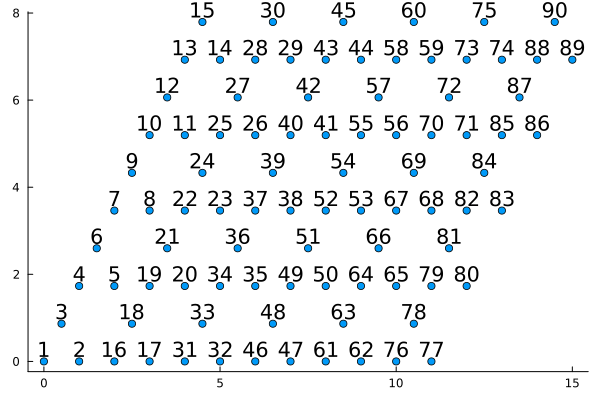

In [16]:
plot_kagome(Nx,Ny)

In [17]:
imp_site = 38
#Imp. potential
V = 4

H_total_imp = get_total_H(V, imp_site, number_mb_list_operators, H1cut, H_Int);
#H_total = get_total_H(0, imp_site, number_mb_list_operators, H1cut, H_Int)

#eigenenergies(dense((H_total+H_total')/2));

# Exact Diagonalization

In [18]:
using DataFrames

function get_energies(pn, E, V, basis)
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), V[i])) 
        PN_Energies[i,2] = E[i] 
    end
    
    # filter
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [19]:
PN

3-element Vector{Int64}:
 0
 1
 2

<font size="4">
    \begin{align*}
    \text{The number of degeneracy (} \mathscr{D} \text{)} = \frac{(N_d+N-1)!}{N_d!(N-1)!}\frac{N_\phi}{N}
    \end{align*}
<end font>

In [29]:
Hermitian_H = (H_total_imp+dagger(H_total_imp))/2
E, V = eigenstates(dense(Hermitian_H))
#E0, V0 = eigenstates(dense((H_total+dagger(H_total))/2))

#filtered particle number
pn = 2.0

df = get_energies(pn, E, V, basis_cut_mb)
#df_0 = get_energies(pn, E0, V0, basis_cut_mb)

# V \neq 0
filtered_energies = Matrix(df)[:,2]
show(stdout, "text/plain", Matrix(df)[:,2][378:465])

# V = 0
#filtered_energies_0 = Matrix(df_0)[:,2];

88-element Vector{Float64}:
 -5.38964059141475
 -5.3415651523530405
 -5.303898174797135
 -5.2973777716930375
 -5.2963664635273
 -5.296136650744346
 -5.2960243295714955
 -5.295956246764315
 -5.295443924967541
 -5.295342481247023
 -5.295122075895382
 -5.294753912551798
 -5.294302189956142
 -5.2941135749124015
 -5.293953566502959
 -5.293582534887918
 -5.293348465688069
 -5.293326916371177
 -5.29243274861398
 -5.2920620753358145
 -5.290864286234965
 -5.290201276349116
 -5.285632145840896
 -5.2819293606098014
 -5.279965160079665
 -5.279547348999634
 -5.277590188487793
 -5.277487282840864
 -5.266712238637053
 -5.240836699857761
 -5.176102837473387
 -5.1567191981123734
 -5.153731659982614
 -5.148987826647647
 -5.148647512576728
 -5.146395089082512
 -5.141914248785765
 -5.141237092793016
 -5.140291306707734
 -5.13962868941126
 -5.133559237124462
 -5.1290589776983895
 -5.124900735479466
 -5.122149030973254
 -5.119509871797039
 -5.117492987343107
 -5.1170580857352705
 -5.1076600102254
 -5.107636

Allta ki fonksiyonun çalışması için, dizide ki filtre edilmiş parçacık sayısı her zaman en büyük değer de olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [30]:
# Eigenstates of filtered particles
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[1:number_of_states];
end

Restricted_Hubbard_States (generic function with 1 method)

In [31]:
r_hubbard_states = Restricted_Hubbard_States(V);

# Densities

In [32]:
NM_MB_Array_Storage = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb));
for m in 1:N
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            NM_MB_Matrix[i,j] = number_mb_list_operators[m].data[i,j]
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end

In [33]:
BL = BR = basis_cut_mb
index_number_op = 4

T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T)

index_eigen_states = 1

expect(Op, r_hubbard_states[index_eigen_states])

0.024723235059736524 + 2.0244087439377778e-19im

<font size="4">
$\sum_{i} <\psi_j|n_i|\psi_j>, \quad \text{for a given j index}$
</font>

In [34]:
index_eig_states = 1

function get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states)
    Sum = 0
    expect_list = []
    for i in 1:N
        T = NM_MB_Array_Storage[:,:,i]
        Op = Operator(BL,BR,T)   
        Sum += expect(Op, r_hubbard_states[index_eig_states])
        push!(expect_list, expect(Op, r_hubbard_states[index_eig_states]))
    end
    return real(expect_list)
end

get_density_profiles (generic function with 1 method)

<font size="4">
    \begin{align*}
    \frac{N}{N_{\Phi}} &= \frac{2}{8}, \quad \text{In the Laughlin State: } \frac{N}{N_{\Phi}}=\frac{2}{4}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles.}
    \end{align*}
</font>

In [35]:
# AVERAGE (Nx=3; Ny=3; N=Nx*Ny*3; cut_off=Nx*Ny; PN=[0,1,2])

# Degeneracy in The Sub-Space for V \neq 0
Degeneracy = 377 
# avg_density = zeros((Nx,Ny)) 
# for index_eig_states in 1:Degeneracy
#     avg_density += reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states),Nx,Ny)
# end    
# avg_density = avg_density / Degeneracy;
avg_density = get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states) ./ Degeneracy;

# Degeneracy in The Sub-Space for V = 0
# Degeneracy_0 = 16
# avg_density_0 = zeros((Nx,Ny))
# for index_eig_states in 1:Degeneracy_0
#     avg_density_0 += reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states_0, index_eig_states),Nx,Ny)
# end    
# avg_density_0 = avg_density_0 / Degeneracy_0;

# Degeneracy_0 => Örgüde sadece 2 quasi-parçacık boştayken geçerli dejenereliktir.
# Ancak bizim bakmak istediğimiz resim, bu parçacıklardan birisini pinlenmiş ve diğerinin ise boşta olmasıdır.

# Lattice and Minimum Distances

In [36]:
# Lattice coordinates
c = get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[1]
coordinates = hcat(first.(c), last.(c));

In [37]:
# Ghost Sites
coordinates_top_left = (coordinates.-(Nx*a1_vec)).+(Ny*a2_vec)
coordinates_top = coordinates.+(Ny*a2_vec)
coordinates_top_right = (coordinates.+(Nx*a1_vec)).+(Ny*a2_vec)
coordinates_left = coordinates.-(Nx*a1_vec)
coordinates_right = coordinates.+(Nx*a1_vec)
coordinates_bottom_left = (coordinates.-(Nx*a1_vec)).-(Ny*a2_vec)
coordinates_bottom = coordinates.-(Ny*a2_vec)
coordinates_bottom_right = (coordinates.+(Nx*a1_vec)).-(Ny*a2_vec)
co_districts = [coordinates_top_left,coordinates_top,coordinates_top_right,coordinates_left,coordinates_right,coordinates,coordinates_bottom_left,coordinates_bottom,coordinates_bottom_right];

In [38]:
# Distance Functions
function find_co(coordinates, p) # coordinates: Distrincts of Periodic Site
    x_co = coordinates[:,1]
    y_co = coordinates[:,2]
    x = hcat(x_co, y_co)[p, 1]
    y = hcat(x_co, y_co)[p, 2]
    return x, y
end

function distance(coordinates_p1, p1, coordinates_p2, p2)
    x2 = find_co(coordinates_p2, p2)[1]
    x1 = find_co(coordinates_p1, p1)[1]
    y2 = find_co(coordinates_p2, p2)[2]
    y1 = find_co(coordinates_p1, p1)[2]
    return sqrt( (x2 - x1)^2 + (y2 - y1)^2 )
end

distance (generic function with 1 method)

In [39]:
# Example of Disctance Function
coordinates_p1=coordinates
p1 = 1
coordinates_p2=coordinates
p2 = 5
distance(coordinates_p1, p1, coordinates_p2, p2)

2.6457513110645907

# Minimum Distances of Equivalent Sites from Center Reference Site

In [40]:
ref_coordinates = coordinates
ref_site = imp_site # Site That Pinned
distances = []
for site_idx in 1:N 
    push!(distances, distance(coordinates, site_idx, ref_coordinates, ref_site))
end
radius_list = sort(unique(distances));

# Density Plot and $Q_{\rho}$ Calculation with Equivalent Sites Conditions

In [41]:
# Find x and y coordinates from given site index

function exp_list0(site_indx)
    
    x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:N)
    y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:N)
    
    x = hcat(x_co, y_co)[site_indx, 1]
    y = hcat(x_co, y_co)[site_indx, 2] 
    
    #!!! 
    # Burada beklenen değerlerin sıralamasının site bazında olduğunu varsaydım!!!!
    #!!!
    exp_val = real(avg_density)[site_indx] 
    
    return x, y, exp_val
end
exp_list0(2)

(1.0, 0.0, 6.44757167559786e-5)

In [42]:
# Find site_index from given x and y coordinates

function exp_list1(Xx, Yy)
    co_list = hcat(x_co, y_co)
    site_indx = intersect(findall(x->x==Xx, co_list[:,1]), findall(x->x==Yy, co_list[:,2]))
    return real(avg_density)[site_indx] 
end

x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:N)
y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:N)
site_index = 2
Xx = x_co[site_index]
Yy = y_co[site_index]
print(site_index," => ",Xx,"\t",Yy," => ",exp_list1(Xx, Yy))

2 => 1.0	0.0 => [6.44757167559786e-5]

In [43]:
z = exp_list1.(x_co, y_co)
z = collect(Iterators.flatten(z));

In [44]:
z[imp_site]

3.705328200652558e-8

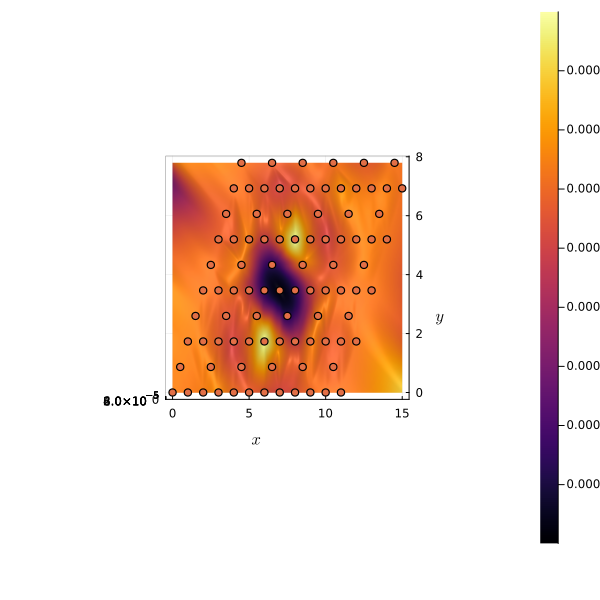

In [45]:
using LaTeXStrings

density = exp_list1.(x_co, y_co)
density = collect(Iterators.flatten(z))
surface(x_co,y_co,z,xlabel=L"$x$",ylabel=L"$y$", camera = (0,90), size=(600,600))

# Plot kagome as project to the plot of density profile
scatter!(x_co, y_co, 0. *density, camera=(0,90), legend=false)

In [46]:
# Stack center of coordinates into a array
All_Coordinates = vcat(coordinates_top_left,coordinates_top,coordinates_top_right,coordinates_left,coordinates,coordinates_right,coordinates_bottom_left,coordinates_bottom,coordinates_bottom_right)
X_Coordinates = All_Coordinates[:,1]
Y_Coordinates =  All_Coordinates[:,2];

In [47]:
# Index and Coordinates of All Sites
all_idx = []
# There is number of 9 distrinct
for i in 1:9 
    for j in 1:N
        push!(all_idx, j)
    end
end

# All_Coordinates_2, her bir N'lik adet satır, sırasıyla bölge koordinatlarını soldan sağa ve aşağıdan yukarıya gösterir.
# Her bir bölgede 1'den N'e site indekslemesi tüm siteler için yapılır.
All_Coordinates_2 = hcat(all_idx,All_Coordinates);

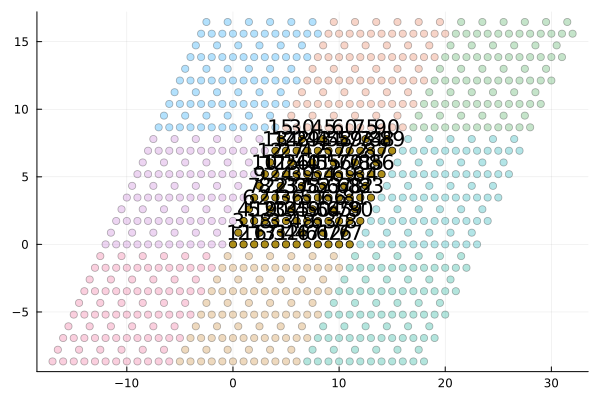

In [48]:
using Plots
center_x = coordinates[N,1]/2
center_y = coordinates[N,2]/2
scatter([coordinates_top_left[:,1]],[coordinates_top_left[:,2]],legend=false, alpha=0.3)
scatter!([coordinates_top[:,1]],[coordinates_top[:,2]], alpha=0.3)
scatter!([coordinates_top_right[:,1]],[coordinates_top_right[:,2]], alpha=0.3)
scatter!([coordinates_left[:,1]],[coordinates_left[:,2]], alpha=0.3)
scatter!([coordinates[:,1]], [coordinates[:,2]],series_annotations = text.(1:N, :bottom))
scatter!([coordinates_right[:,1]],[coordinates_right[:,2]], alpha=0.3)
scatter!([coordinates_bottom_left[:,1]],[coordinates_bottom_left[:,2]], alpha=0.3)
scatter!([coordinates_bottom[:,1]],[coordinates_bottom[:,2]], alpha=0.3)
scatter!([coordinates_bottom_right[:,1]],[coordinates_bottom_right[:,2]], alpha=0.3)

In [49]:
# Example of Find Equivalent Site 
XX = 9.5 # 0 -> coordinates (X Coordinates of Center Distrinct Site)
YY = 6.06217782649107 # 0 -> coordinates (Y Coordinates of Center Distrinct Site)
# Önce verilen koordinat All_Coordinates_2'de hangi satırda olduğu belirlenir.
Intersect = intersect(findall(x->x==XX, All_Coordinates[:,1]), findall(x->x==YY, All_Coordinates[:,2]))
# Daha sonra, o sitenin, hangi merkez siteye karşılık geldiği tespit edilir.
Equivalent_Site = All_Coordinates_2[:,1][Intersect][1]

57

In [50]:
function Get_Site_Idx(XX, YY)
    Intersect = intersect(findall(x->x==XX, All_Coordinates[:,1]), findall(x->x==YY, All_Coordinates[:,2]))
    Equivalent_Site = All_Coordinates_2[:,1][Intersect][1]
    return Equivalent_Site
end
Get_Site_Idx(-3.5, 4.330127018922193)

54

In [51]:
ref_district = coordinates # Referance Distrinc is the Center Distrinct

# Find imp. site coordinates in the center distrinct
Ref_Site_X = ref_district[:,1][imp_site]
Ref_Site_Y = ref_district[:,2][imp_site]

# Hangi siteler, ilgili yarı-çap içerisinde şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    inner_sites = []
    
    for i in 1:N*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "Get_Site_Idx" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, Get_Site_Idx(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Radius = 1
Inner_Sites(Radius)

5-element Vector{Any}:
 37
 38
 39
 51
 52

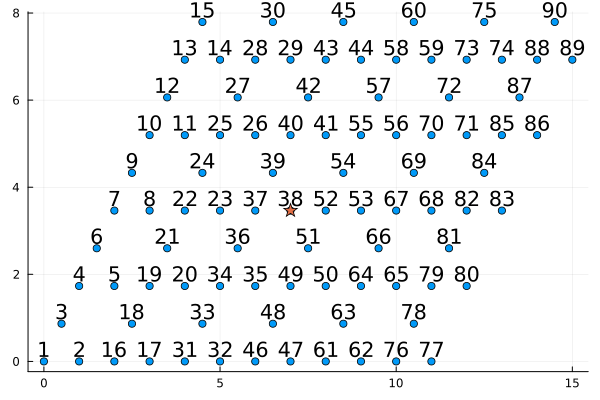

In [52]:
scatter(x_co,y_co,legend=false,series_annotations = text.(1:N, :bottom))
x_imp = exp_list0(imp_site)[1];y_imp=exp_list0(imp_site)[2]
scatter!([x_imp], [y_imp],markershape=:star5,markersize=7)

\begin{align*}
&Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right) \\ \\
&\text{In Hofstadter model:}\\
&N_x=8, N_y=10, N=3, \mathcal{D}=7 \\ \\
&<n_i>_{V=0} \approx \frac{N}{N_y(N_{\Phi}-1)} = \frac{N}{N_y(N_x-1)} = \frac{3}{70} \\ \\
&\text{In kagome lattice:} \\
&N_x=4, N_y=2, N=3, \mathcal{D}=7 \\ \\
&<n_i>_{V=0} \approx \frac{N}{3(N_{\Phi}-1)} = \frac{N}{3(N_xN_y-1)} =  \frac{1}{7} \\
\end{align*}

In [60]:
#fonctionize the ref. partc. den. 

In [61]:
density_list = []
density_list_2 = []
summ_list = []

for i in radius_list
    
    summ = 0

    for j in Inner_Sites(i)
        
        # r içindeki her bir sitenin ortalama yoğunluğu 
        push!(density_list, collect(Iterators.flatten((2/87 .- avg_density|>transpose)))[j])
        # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
        
        # aynı yoğunluklar gelirse sadece onların birisini tut
        density_list_2 = unique!(density_list)
        
        # her biri biricik ve her bir site için olan yoğunlukları topla
        summ = sum(density_list_2)
    end
    
    # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
    push!(summ_list, summ)
    println("Rho:",round(i,digits=3),"\t","Q_rho:",summ)
end

Rho:0.0	Q_rho:0.02298846869384443
Rho:1.0	Q_rho:0.1148913408495316
Rho:1.0	Q_rho:0.1148913408495316
Rho:1.732	Q_rho:0.20658637085671028
Rho:1.732	Q_rho:0.20658637085671028
Rho:2.0	Q_rho:0.32120274086264267
Rho:2.0	Q_rho:0.32120274086264267
Rho:2.0	Q_rho:0.32120274086264267
Rho:2.646	Q_rho:0.5045954398061997
Rho:3.0	Q_rho:0.5963044191191775
Rho:3.464	Q_rho:0.7339075001643502
Rho:3.464	Q_rho:0.7339075001643502
Rho:3.606	Q_rho:0.8715015666442721
Rho:4.0	Q_rho:1.0090711227512348
Rho:4.0	Q_rho:1.0090711227512348
Rho:4.359	Q_rho:1.1466494705018975
Rho:4.359	Q_rho:1.1466494705018975
Rho:4.583	Q_rho:1.330059397840357
Rho:5.0	Q_rho:1.4217606580415723
Rho:5.196	Q_rho:1.7426881366693323
Rho:5.292	Q_rho:1.7426881366693323
Rho:5.568	Q_rho:1.8343804550043095
Rho:6.0	Q_rho:1.9031513950340118
Rho:6.083	Q_rho:1.9031513950340118
Rho:6.245	Q_rho:1.9489972487825897
Rho:6.928	Q_rho:1.9489972487825897
Rho:7.0	Q_rho:1.9489972487825897
Rho:7.211	Q_rho:1.9489972487825897
Rho:7.81	Q_rho:1.9489972487825897
Rho:8

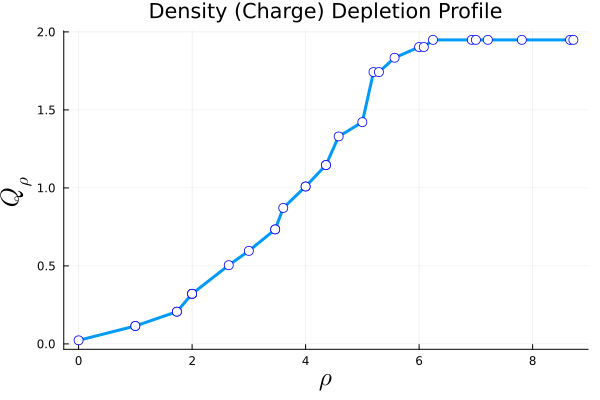

In [65]:
Plots.plot(radius_list, summ_list, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, m = (5, :white, stroke(1, :blue)))
# g(x)=2/87;x=0
# Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,7))

In [47]:
#U çok küçükken (Band-Gap büyüdüğünde) subspace enerjileri, real-space enerjilerine yakınsar:

# MB_Hamiltonian = Kagome_Finite_U(Nx,Ny,Basis_MB,U,sp_op)
# real_space_finite_u = eigenenergies(dense(MB_Hamiltonian)); sub_space_finite_u = E_States[1]
# plot(1:length(real_space_finite_u[1:21]),real_space_finite_u,seriestype=:scatter,markershape=:star5,markersize=7,label="Real-Space")
# plot!(1:length(sub_space_finite_u),sub_space_finite_u,seriestype=:scatter,label="Sub-Space",legend=:topleft)
# title!("U=$(U)");xlabel!("n");ylabel!("E")